In [73]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import dataObject, plot_predictor
from collab2.foraging.toolkit.proximity import _generate_proximity_predictor
from collab2.foraging.toolkit.proximity import _piecewise_proximity_function
from collab2.foraging.toolkit.proximity import _piecewise_proximity_function as prx
from collab2.foraging.toolkit.waic import compute_waic
from collab2.utils import find_repo_root

logging.basicConfig(format="%(message)s", level=logging.INFO)
from functools import partial

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 300
sampling_rate = 0.001 if smoke_test else 0.01

notebook_starts = time.time()

## Data processing

In [74]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF=ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF=sps_sub)

original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1848, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 279
resulting_shape: (617, 4)


/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/utils.py

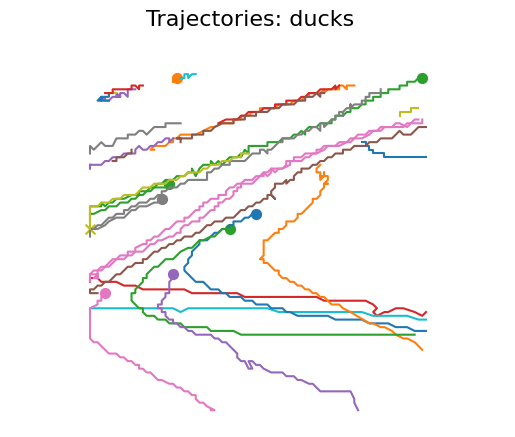

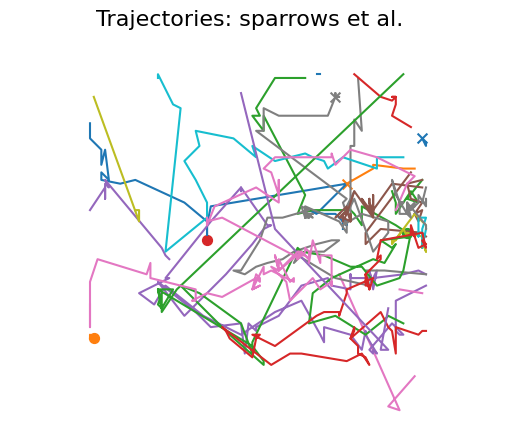

In [75]:
fig = ft.plot_trajectories(ducks_object.foragersDF, "ducks", legend=False)
# too many birds to show legend
fig.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_ducks.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt = ft.plot_trajectories(sps_object.foragersDF, "sparrows et al.", legend=False)
plt.show()
path = os.path.join(root, "docs/figures/fig_bird_trajectories_sps.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

## Finding optimal parameters for ducks

In [76]:
# init ducks search for access predictor
data_object = ducks_object
window_size = 30
sampling_fraction = 0.2


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

predictor_kwargs = {}

local_windows_kwargs = {
    "window_size": window_size,
    "sampling_fraction": sampling_fraction,
    "skip_incomplete_frames": False,
}

ducks_derived_DF = ft.derive_predictors_and_scores(
    data_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-10-17 13:47:22,870 - nextStep_linear completed in 2.03 seconds.
2024-10-17 13:47:24,309 - nextStep_sublinear completed in 1.44 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 19072/1705366 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



In [77]:
def get_proximity_single_marginal(rep, opt, data_object):

    if rep > opt:
        return 0

    predictor_kwargs = {}

    predictor_name = "proximity" + str(rep) + str(opt)

    ppr = _generate_proximity_predictor(
        data_object.foragers,
        data_object.foragersDF,
        local_windows=data_object.local_windows,
        predictor_name=predictor_name,
        interaction_length=90,
        interaction_constraint=None,
        interaction_constraint_params=None,
        proximity_contribution_function=_piecewise_proximity_function,
        repulsion_radius=rep,
        optimal_distance=opt,
        proximity_decay=0.5,
    )

    ppr_df = pd.concat([pd.concat(df, axis=0) for df in ppr], axis=0)

    derived_DF_new = data_object.derivedDF.merge(
        ppr_df[["x", "y", "time", "forager", ppr_df.columns[-1]]],
        on=[
            "x",
            "y",
            "time",
            "forager",
        ],
        how="left",
    )

    predictors = [predictor_name]
    outcome_vars = ["nextStep_sublinear"]

    predictor_dict, outcome_dict = ft.prep_DF_data_for_inference(
        derived_DF_new,
        predictors,
        outcome_vars,
        subsample_rate=0.1,
    )

    model = ft.HeteroskedasticLinear(predictor_dict, outcome_dict)

    outcome = ft.get_samples(
        model=model,
        predictors=predictor_dict,
        outcome=outcome_dict,
        num_svi_iters=900,
        num_samples=500,
        plot=False,
        verbose=False,
    )

    waic = compute_waic(
        model=model,
        guide=outcome["guide"],
        num_particles=1000,
        sites=outcome_vars,
        max_plate_nesting=9,
        predictors=predictor_dict,
        outcome=outcome_dict,
    )["waic"]
    # marginal =  outcome['summaries'][f"weight_continuous_{predictor_name}_nextStep_linear"]['mean'].item()

    return -waic.detach().item()  # marginal

In [78]:
force = False  # left to facilitate potential future updates

get_proximity_single_marginal_ducks = partial(
    get_proximity_single_marginal, data_object=ducks_object
)

ducs_proximity_single_optimizer_path = os.path.join(
    root, "docs/foraging/central-park-birds/ducks_proximity_single_optimizer.pkl"
)
pbounds = {
    "rep": (2, 40),
    "opt": (5, 70),
}

if os.path.exists(ducs_proximity_single_optimizer_path) and not force:
    print("Loading pre-trained ducks proximity optimizer")
    with open(ducs_proximity_single_optimizer_path, "rb") as f:
        optimizer_ducks = dill.load(f)

else:

    optimizer_ducks = BayesianOptimization(
        f=get_proximity_single_marginal_ducks,
        pbounds=pbounds,
        random_state=2,
        verbose=2,
    )

    log_path = os.path.join(root, "ducks_optimization_logs.log")

    if not any(
        isinstance(subscriber, JSONLogger)
        for subscriber in optimizer._events.get(Events.OPTIMIZATION_STEP, [])
    ):
        logger = JSONLogger(path=log_path)
        optimizer_ducks.subscribe(Events.OPTIMIZATION_STEP, logger)

    optimizer_ducks.probe(
        params={"rep": 2, "opt": 7.11},
        lazy=True,
    )

    optimizer_ducks.maximize(
        init_points=2,
        n_iter=20,
    )

    with open(ducs_proximity_single_optimizer_path, "wb") as f:
        dill.dump(optimizer_ducks, f)

Loading pre-trained ducks proximity optimizer


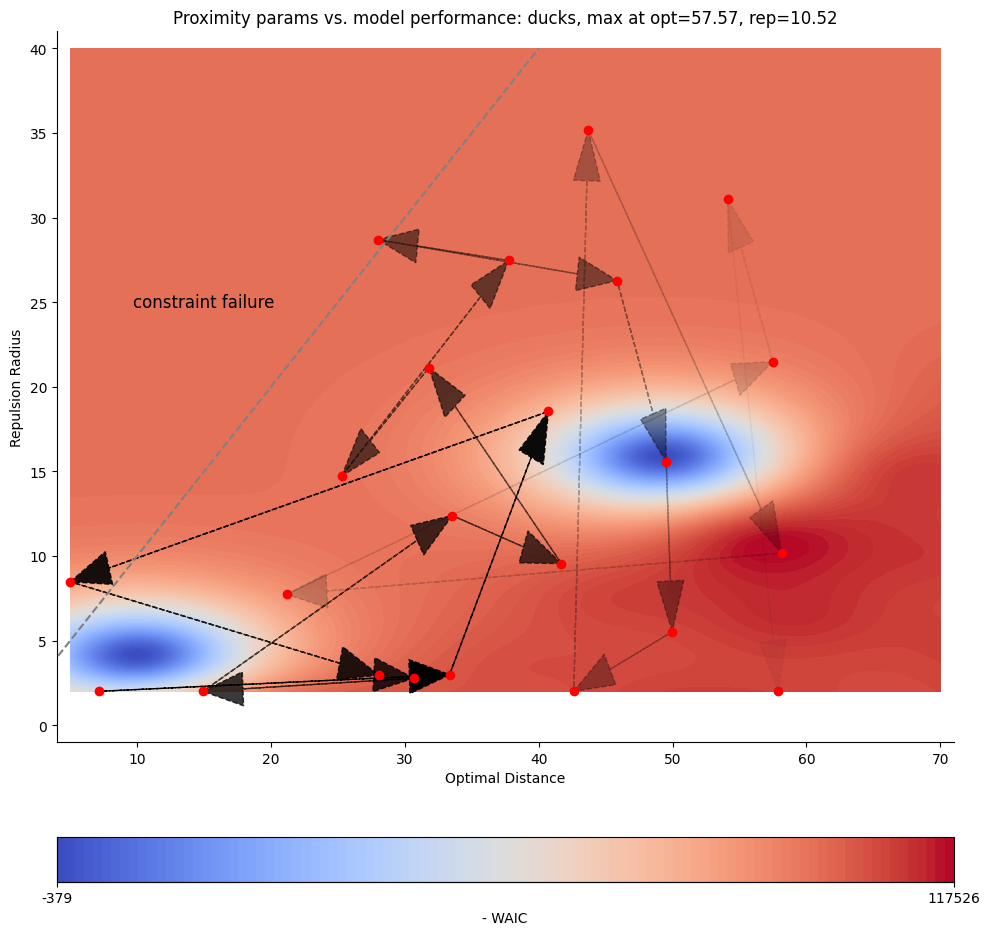

In [79]:
def plot_optimization(optimizer, pbounds):
    size_r, size_o = 1000, 1000

    rep = np.linspace(pbounds["rep"][0], pbounds["rep"][1], size_r)
    opt = np.linspace(pbounds["opt"][0], pbounds["opt"][1], size_o)

    (
        rep__,
        opt__,
    ) = np.meshgrid(rep, opt)

    reptopt = np.array([[r, o] for r, o in zip(rep__.ravel(), opt__.ravel())])
    rep_ = np.array([r["params"]["rep"] for r in optimizer.res])
    opt_ = np.array([r["params"]["opt"] for r in optimizer.res])

    post_est = optimizer._gp.predict(reptopt).reshape(size_r, size_o)

    where_max = np.unravel_index(np.argmax(post_est, axis=None), post_est.shape)
    max_rep = rep[where_max[0]]
    max_opt = opt[where_max[1]]

    vmin, vmax = np.min(post_est), np.max(post_est)
    levels = np.linspace(vmin, vmax, 100)

    plt.figure(figsize=(10, 10))

    contour = plt.contourf(opt, rep, post_est, cmap=plt.cm.coolwarm, levels=levels)
    plt.scatter(opt_, rep_, color="r", zorder=10)
    cbar = plt.colorbar(contour, orientation="horizontal", pad=0.1)
    cbar.set_label("- WAIC")

    cbar_ticks = [vmin, vmax]
    cbar.set_ticks(cbar_ticks)
    cbar.ax.set_xticklabels([f"{int(tick)}" for tick in cbar_ticks])

    plt.plot([0, 40], [0, 40], linestyle="--", color="grey", zorder=9)

    for i in range(len(opt_) - 1):
        alpha = 1 - (i / (len(opt_) - 1))
        plt.arrow(
            opt_[i],
            rep_[i],
            opt_[i + 1] - opt_[i],
            rep_[i + 1] - rep_[i],
            head_width=2,
            head_length=3,
            fc="black",
            ec="black",
            linestyle="dashed",
            alpha=alpha,
            zorder=5,
            length_includes_head=True,
        )

    plt.text(
        15,
        25,
        "constraint failure",
        fontsize=12,
        color="black",
        ha="center",
        va="center",
    )

    sns.despine()
    plt.ylim(-1, 41)
    plt.xlim(4, 71)
    plt.xlabel("Optimal Distance")
    plt.ylabel("Repulsion Radius")
    plt.title(
        f"Proximity params vs. model performance: ducks, max at opt={max_opt:.2f}, rep={max_rep:.2f}"
    )
    plt.tight_layout()
    plt.show()

    return max_rep, max_opt


max_rep_ducks, max_opt_ducks = plot_optimization(optimizer_ducks, pbounds)

## Inspect optimal predictors for ducks

In [81]:
data_object = ducks_object
window_size = 30
sampling_fraction = 0.2


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": 90,
        "optimal_distance": max_opt_ducks,
        "repulsion_radius": max_rep_ducks,
        "proximity_decay": 0.5,
    },
}

local_windows_kwargs = {
    "window_size": window_size,
    "sampling_fraction": sampling_fraction,
    "skip_incomplete_frames": False,
}

ducks_derived_DF = ft.derive_predictors_and_scores(
    data_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-10-17 13:48:45,238 - proximity completed in 23.34 seconds.
2024-10-17 13:48:47,281 - nextStep_linear completed in 2.04 seconds.
2024-10-17 13:48:49,318 - nextStep_sublinear completed in 2.04 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 19072/1705366 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/visualization.py:100: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



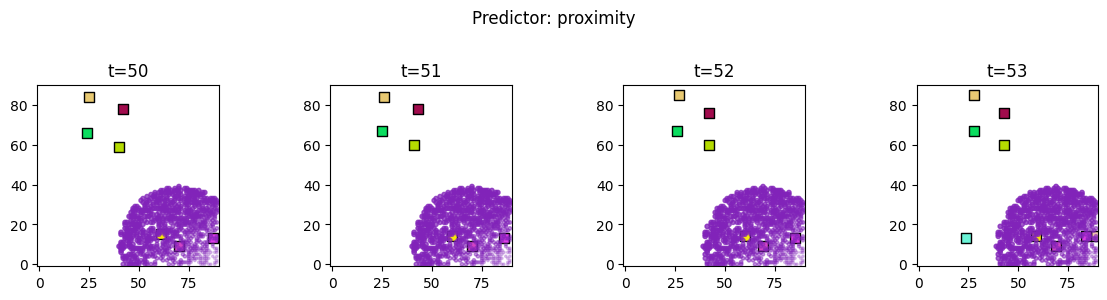

In [82]:
predictor_name = "proximity"
plot_predictor(
    ducks_object.foragers,
    ducks_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(50, 54),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(29)),
    forager_predictor_indices=[2],  # list(range(29))#[2],#list(range(20)),
)

In [88]:
predictors = ["proximity"]
outcome_vars = ["nextStep_sublinear"]

predictor_dict, outcome_dict = ft.prep_DF_data_for_inference(
    ducks_derived_DF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

ft.visualise_forager_predictors(
    predictors=[
        predictor_dict["proximity"],
    ],
    predictor_names=["proximity"],
    outcome_name="nextStep_sublinear",
    outcome=outcome_dict["nextStep_sublinear"],
    sampling_rate=0.3,
)

Sample size: 168629


## Finding optimal parameters for sparrows

In [90]:
# init sparows search for access predictor
data_object = sps_object
window_size = 40  # they have larger step sizes, so larger window
sampling_fraction = 0.2


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

predictor_kwargs = {}

local_windows_kwargs = {
    "window_size": window_size,
    "sampling_fraction": sampling_fraction,
    "skip_incomplete_frames": False,
}

sps_derived_DF = ft.derive_predictors_and_scores(
    data_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-10-17 13:53:32,436 - nextStep_linear completed in 0.71 seconds.
2024-10-17 13:53:33,156 - nextStep_sublinear completed in 0.72 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 35720/1000359 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



In [91]:
get_proximity_single_marginal_sps = partial(
    get_proximity_single_marginal, data_object=sps_object
)

force = False  # left to facilitate potential future updates

sps_proximity_single_optimizer_path = os.path.join(
    root, "docs/foraging/central-park-birds/sparrows_proximity_single_optimizer.pkl"
)
pbounds = {
    "rep": (2, 40),
    "opt": (5, 70),
}

if os.path.exists(sps_proximity_single_optimizer_path) and not force:
    print("Loading pre-trained sparrows proximity optimizer")
    with open(sps_proximity_single_optimizer_path, "rb") as f:
        optimizer_sps = dill.load(f)

else:

    optimizer_sps = BayesianOptimization(
        f=get_proximity_single_marginal_sps,
        pbounds=pbounds,
        random_state=2,
        verbose=2,
    )

    log_path = os.path.join(root, "sparrows_optimization_logs.log")

    if not any(
        isinstance(subscriber, JSONLogger)
        for subscriber in optimizer_sps._events.get(Events.OPTIMIZATION_STEP, [])
    ):
        logger = JSONLogger(path=log_path)
        optimizer_sps.subscribe(Events.OPTIMIZATION_STEP, logger)

    optimizer_sps.probe(
        params={"rep": 2, "opt": 7.11},
        lazy=True,
    )

    optimizer_sps.maximize(
        init_points=2,
        n_iter=20,
    )

    with open(sps_proximity_single_optimizer_path, "wb") as f:
        dill.dump(optimizer_sps, f)

Loading pre-trained sparrows proximity optimizer


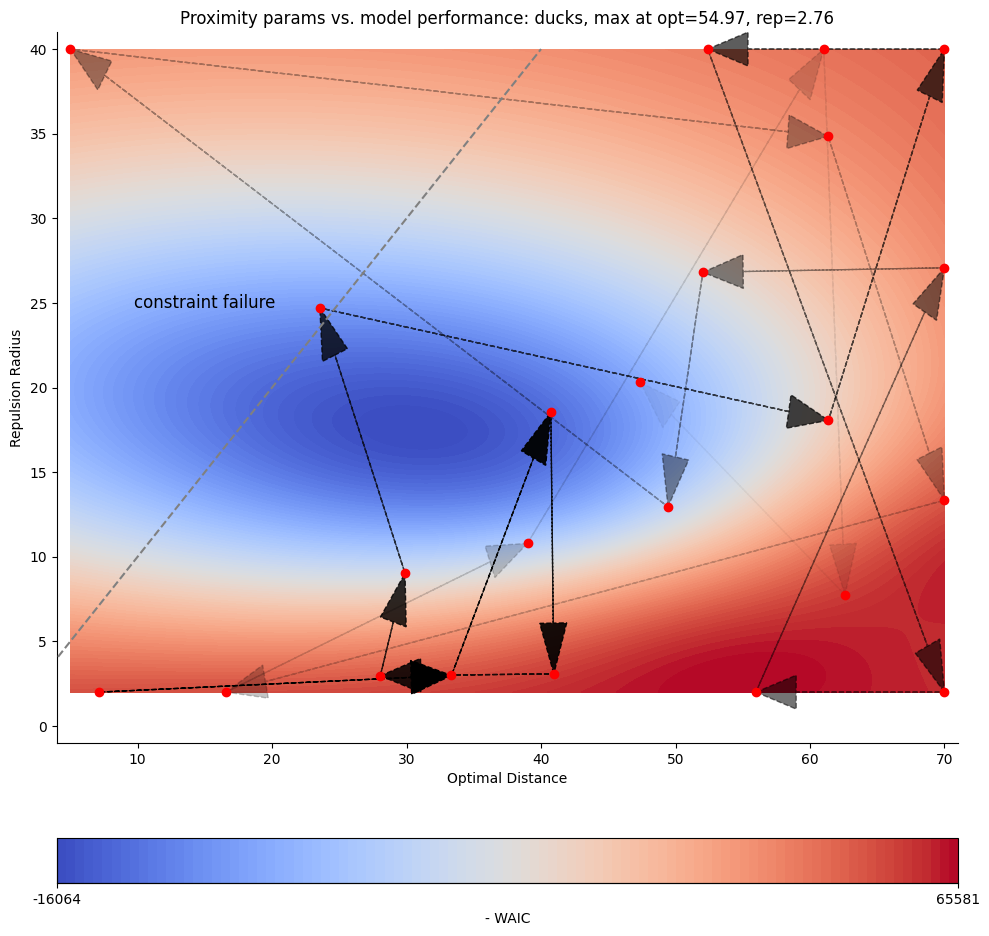

In [92]:
max_rep_sps, max_opt_sps = plot_optimization(optimizer_sps, pbounds)

In [94]:
def sample_from_optimizer(optimizer, pbounds, num_samples=20):

    size_r, size_o = 100, 100

    rep = np.linspace(pbounds["rep"][0], pbounds["rep"][1], size_r)
    opt = np.linspace(pbounds["opt"][0], pbounds["opt"][1], size_o)

    (
        rep__,
        opt__,
    ) = np.meshgrid(rep, opt)

    reptopt = np.array([[r, o] for r, o in zip(rep__.ravel(), opt__.ravel())])
    rep_ = np.array([r["params"]["rep"] for r in optimizer.res])
    opt_ = np.array([r["params"]["opt"] for r in optimizer.res])

    post_est = optimizer._gp.predict(reptopt).reshape(size_r, size_o)

    post_est_shifted = post_est - np.min(post_est) if np.min(post_est) < 0 else post_est
    probs = post_est_shifted / np.sum(post_est_shifted)

    num_samples = num_samples
    sampled_indices = np.random.choice(
        reptopt.shape[0], size=num_samples, p=probs.ravel()
    )
    sampled_inputs = reptopt[sampled_indices]

    filtered_samples = sampled_inputs[sampled_inputs[:, 0] <= sampled_inputs[:, 1]]

    return filtered_samples


samples_ducks = sample_from_optimizer(optimizer_ducks, pbounds)

## Inspect and compare results for ducks and sparrows

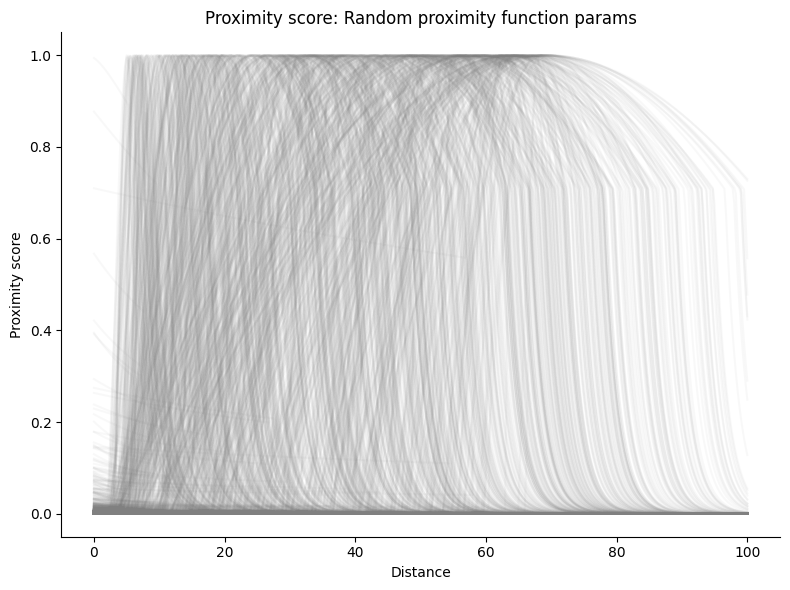

In [120]:
# first, what would be think of the proximity preferences without any information?
# plot uninformed prior


def sample_random_params(num_samples):
    opt_samples = np.random.uniform(5, 70, num_samples)
    rep_samples = np.random.uniform(2, opt_samples, num_samples)  # rep < opt
    return np.column_stack((rep_samples, opt_samples))


def plot_proximity_function_uninformed(num_samples, title, xlim=None):
    samples = sample_random_params(num_samples)
    distances = np.linspace(0, 100, 400)

    fig, ax = plt.subplots(figsize=(8, 6))

    for s in samples:
        rep, opt = s
        scores = prx(distances, rep, opt, 0.5)
        ax.plot(distances, scores, alpha=0.05, color="grey")

    ax.set_title(f"Proximity score: {title}")
    ax.set_ylabel("Proximity score")
    ax.set_xlabel("Distance")

    if xlim is not None:
        ax.set_xlim(xlim)

    sns.despine()

    plt.tight_layout()
    plt.show()


plot_proximity_function_uninformed(1000, "Random proximity function params")

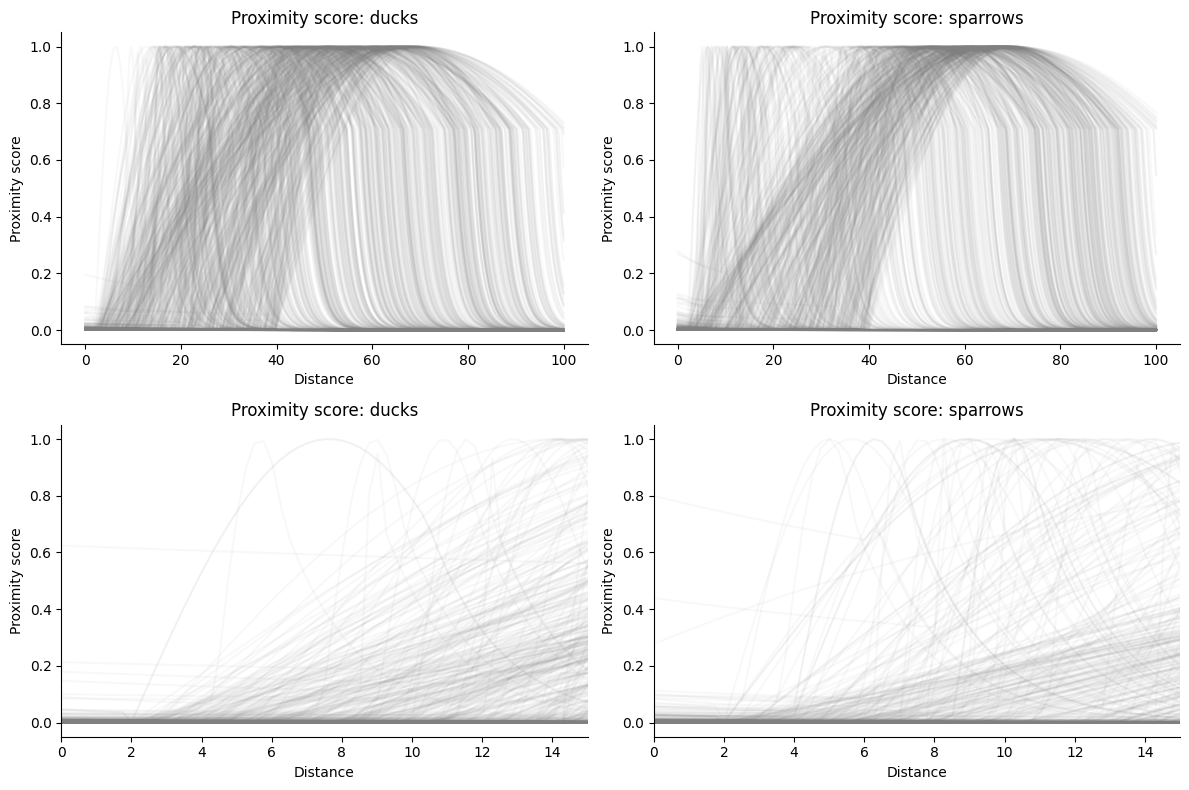

In [122]:
# now sampling from the gaussian process
# with probalility proportionate to the estimated WAIC


def plot_proximity_function_estimate(optimizer, num_samples, title, ax=None, xlim=None):
    samples = sample_from_optimizer(optimizer, pbounds, num_samples=num_samples)
    distances = np.linspace(
        0, 100, 400
    )  # Note we can't extrapolate beyond 100, no data

    if ax is None:
        fig, ax = plt.subplots()

    for s in samples:
        rep, opt = s
        scores = prx(distances, rep, opt, 0.5)
        ax.plot(distances, scores, alpha=0.05, color="grey")

    ax.set_title(f"Proximity score: {title}")
    ax.set_ylabel("Proximity score")
    ax.set_xlabel("Distance")

    if xlim is not None:
        ax.set_xlim(xlim)

    sns.despine()
    return ax


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

plot_proximity_function_estimate(optimizer_ducks, 1000, "ducks", ax=ax1)
plot_proximity_function_estimate(optimizer_sps, 1000, "sparrows", ax=ax2)
plot_proximity_function_estimate(optimizer_ducks, 1000, "ducks", ax=ax3, xlim=(0, 15))
plot_proximity_function_estimate(optimizer_sps, 1000, "sparrows", ax=ax4, xlim=(0, 15))


plt.tight_layout()
plt.show()

# sparrows prefer somewhat larger distances, but also have smaller repulsion radii

In [112]:
data_object = sps_object
window_size = 40
sampling_fraction = 0.2


score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": 90,
        "optimal_distance": max_opt_sps,
        "repulsion_radius": max_rep_sps,
        "proximity_decay": 0.5,
    },
}

local_windows_kwargs = {
    "window_size": window_size,
    "sampling_fraction": sampling_fraction,
    "skip_incomplete_frames": False,
}

sps_derived_DF = ft.derive_predictors_and_scores(
    data_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

2024-10-17 14:04:26,109 - proximity completed in 1.94 seconds.
2024-10-17 14:04:26,572 - nextStep_linear completed in 0.46 seconds.
2024-10-17 14:04:27,017 - nextStep_sublinear completed in 0.44 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 35720/1000359 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      



/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/visualization.py:100: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



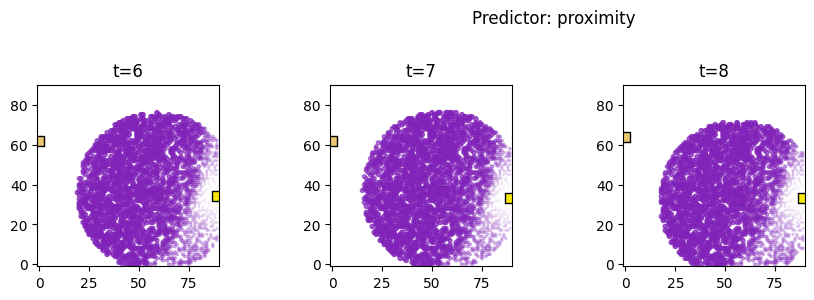

In [113]:
predictor_name = "proximity"
len(data_object.foragers)

plot_predictor(
    data_object.foragers,
    data_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(6, 9),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(28)),
    forager_predictor_indices=[2],  # list(range(29))#[2],#list(range(20)),
)

In [114]:
predictors = ["proximity"]
outcome_vars = ["nextStep_sublinear"]

predictor_dict, outcome_dict = ft.prep_DF_data_for_inference(
    sps_derived_DF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

ft.visualise_forager_predictors(
    predictors=[
        predictor_dict["proximity"],
    ],
    predictor_names=["proximity"],
    outcome_name="nextStep_sublinear",
    outcome=outcome_dict["nextStep_sublinear"],
    sampling_rate=0.3,
)

Sample size: 96464
